In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='1'

from fastai import *
from fastai.vision import *
from fastai.vision.gan import *
from superRes.generators import *
from superRes.critics import *
from superRes.dataset import *
from superRes.loss import *
from superRes.save import *
from superRes.fid_loss import *
from superRes.ssim import *
from superRes.metrics import *

import torchvision
import geffnet # efficient/ mobile net

In [2]:
path = Path('./dataset/')

path_fullRes = path/'DIV2K_train_HR'

path_lowRes_512 = path/'DIV2K_train_LR_512_QF20'

proj_id = 'unet_superRes_mobilenetV3_LPIPS_Tuned'

gen_name = proj_id + '_gen'
crit_name = proj_id + '_crit'

name_gen = proj_id + '_image_gen'
path_gen = path/name_gen

generate_training_img = False

In [3]:
crit_name

'unet_superRes_mobilenetV3_LPIPS_Tuned_crit'

In [5]:
def save_preds(dl):
    i=0
    names = dl.dataset.items
    
    for b in dl:
        preds = learn_gen.pred_batch(batch=b, reconstruct=True)
        for o in preds:
            o.save(path_gen/names[i].name)
            i += 1
            

def save_gen_images(data_gen):
    if path_gen.exists(): shutil.rmtree(path_gen)
    path_gen.mkdir(exist_ok=True)
    save_preds(data_gen.fix_dl)

In [6]:
if generate_training_img:    
    model = geffnet.mobilenetv3_rw
    loss_func = lpips_loss()

    bs=1
    sz=512
    nf_factor = 2
    pct_start = 1e-8

    data_gen = get_DIV2k_data_QF(path_lowRes_512, path_fullRes, bs=bs, sz=sz)

    learn_gen = gen_learner_wide(data=data_gen,
                                 gen_loss=loss_func,
                                 arch = model,
                                 nf_factor=nf_factor)

    weights = "/data/students_home/fmameli/repos/SuperRes/models/unet_superRes_mobilenetV3_LPIPS_Tuned_gen_512px_5"
    learn_gen.load(weights, with_opt=False)

    dl = data_gen.fix_dl
    print(dl.dataset.items)
    save_gen_images(data_gen)

In [3]:
def get_crit_data(classes, bs, sz):
    src = ImageList.from_folder(path, include=classes, recurse=True).split_by_rand_pct(0.1, seed=42)
    ll = src.label_from_folder(classes=classes)
    data = (ll.transform(get_transforms(max_zoom=2.), size=sz).databunch(bs=bs).normalize(imagenet_stats))
    return data

In [8]:
bs = 3
sz = 192

In [9]:
data_crit = get_crit_data([name_gen, "DIV2K_train_HR"], bs=bs, sz=sz)

In [ ]:
data_crit.show_batch(rows=6, ds_type=DatasetType.Train, imgsize=3)

In [10]:
learn_critic = colorize_crit_learner(data=data_crit, nf=64)

In [13]:
learn_critic.fit_one_cycle(5, 1e-6)

epoch,train_loss,valid_loss,accuracy_thresh_expand,time
0,0.677713,0.680835,0.568773,00:30
1,0.677636,0.681018,0.563326,00:30
2,0.687778,0.681271,0.560712,00:31
3,0.674024,0.681494,0.558896,00:30
4,0.692564,0.681442,0.559477,00:30


In [14]:
learn_critic.save("/data/students_home/fmameli/repos/SuperRes/models/" + crit_name + "_0")

In [16]:
data_crit = get_crit_data([name_gen, "DIV2K_train_HR"], bs=2, sz=256)

learn_critic.fit_one_cycle(5, 1e-6)

epoch,train_loss,valid_loss,accuracy_thresh_expand,time
0,0.679278,0.680712,0.560784,00:30
1,0.690020,0.680147,0.562600,00:29
2,0.681208,0.680056,0.562600,00:30
3,0.673226,0.679997,0.562672,00:30
4,0.676947,0.680009,0.562600,00:30


In [17]:
learn_critic.save("/data/students_home/fmameli/repos/SuperRes/models/" + crit_name + "_0")

In [18]:
data_crit = get_crit_data([name_gen, "DIV2K_train_HR"], bs=1, sz=512)

learn_critic.fit_one_cycle(5, 1e-5)

epoch,train_loss,valid_loss,accuracy_thresh_expand,time
0,0.681881,0.681222,0.557153,00:30
1,0.679984,0.680011,0.560639,00:30
2,0.689043,0.679308,0.565940,00:29
3,0.682459,0.676454,0.568700,00:30
4,0.662421,0.677259,0.564415,00:30


In [ ]:
learn_critic.save("/data/students_home/fmameli/repos/SuperRes/models/" + crit_name + "_0")

In [ ]:
learn_critic.show_results()
fn = data_crit.valid_dl.x.items[2]; fn
img = open_image(fn)
learn_critic.predict(img)

# GAN

In [4]:
learn_crit=None
learn_gen=None
gc.collect()

0

In [5]:
lr=2e-5
sz=512
bs=1

In [ ]:
data_crit = get_crit_data([name_gen, 'test'], bs=bs, sz=sz)

learn_crit = colorize_crit_learner(data=data_crit, nf=64)

weights = "/data/students_home/fmameli/repos/SuperRes/models/unet_superRes_mobilenetV3_LPIPS_Tuned_crit_0"
learn_crit.load(weights, with_opt=False)

In [4]:
model = geffnet.mobilenetv3_rw
loss_func = lpips_loss()

bs=1
sz=512

data_gen = get_DIV2k_data_QF(path_lowRes_512, path_fullRes, bs=bs, sz=sz)

learn_gen = gen_learner_wide(data=data_gen,
                             gen_loss=loss_func,
                             arch = model,
                             nf_factor=2)

weights = "/data/students_home/fmameli/repos/SuperRes/models/unet_wideNf2_superRes_mobilenetV3_GAN_0"
learn_gen.load(weights, with_opt=False)

Setting up Perceptual loss...
Loading model from: /data/students_home/fmameli/anaconda3/envs/fastai/lib/python3.6/site-packages/perceptual_similarity/weights/v0.1/vgg.pth
...[net-lin [vgg]] initialized
...Done


Learner(data=ImageDataBunch;

Train: LabelList (800 items)
x: ImageImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
Path: dataset/DIV2K_train_LR_512_QF20;

Valid: LabelList (100 items)
x: ImageImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
Path: dataset/DIV2K_train_LR_512_QF20;

Test: None, model=DynamicUnetWide(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): HardSwish()
      (3): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
 

In [8]:
checkpoint_num = 0

In [9]:
gen_new_checkpoint_name = gen_name + "_GAN_" + str(checkpoint_num)

In [10]:
gen_new_checkpoint_name

'unet_superRes_mobilenetV3_LPIPS_Tuned_gen_GAN_0'

In [38]:
switcher = partial(AdaptiveGANSwitcher, critic_thresh=0.55)
learn_gan = GANLearner.from_learners(learn_gen, learn_crit, weights_gen=(1.0,1.5), show_img=True, switcher=switcher,
                                 opt_func=partial(optim.Adam, betas=(0.,0.9)), wd=1e-3)
learn_gan.callback_fns.append(partial(GANDiscriminativeLR, mult_lr=5.))
learn_gan.callback_fns.append(partial(GANSaveCallback, learn_gen=learn_gen, filename=gen_new_checkpoint_name, save_iters=100))

In [17]:
learn_gan.data = get_DIV2k_data_QF(path_lowRes_512, path_fullRes, bs=bs, sz=sz)
learn_gen.freeze_to(-1)
learn_gan.fit(1,lr)

In [73]:
learn_gan.data = get_DIV2k_data_QF(path_lowRes_512, path_fullRes, bs=bs, sz=sz)
learn_gen.freeze_to(-1)
learn_gan.fit(1, 1e-5)

epoch,train_loss,valid_loss,gen_loss,disc_loss,time
0,0.688703,0.709850,1.864734,0.685436,15:03


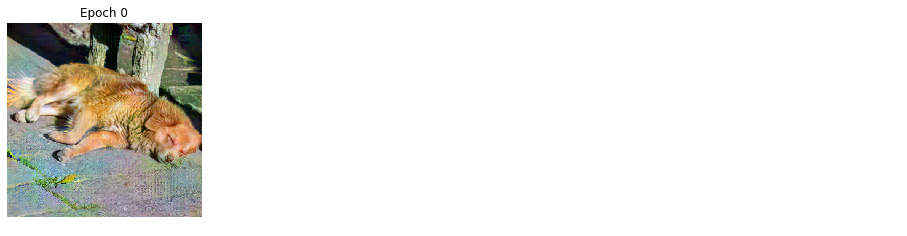

In [45]:
learn_gan.data = get_DIV2k_data_QF(path_lowRes_512, path_fullRes, bs=bs, sz=sz)
learn_gen.unfreeze()
learn_gan.fit(1, 1e-5)

# Validation

In [46]:
learn_gen.metrics.append(SSIM_Metric_gen())
learn_gen.metrics.append(SSIM_Metric_input())
learn_gen.metrics.append(LPIPS_Metric_gen())
learn_gen.metrics.append(BRISQUE_Metric_gen())
learn_gen.metrics.append(BRISQUE_Metric_input())
learn_gen.metrics.append(BRISQUE_Metric_target())
learn_gen.metrics.append(NIQE_Metric_gen())
learn_gen.metrics.append(NIQE_Metric_input())
learn_gen.metrics.append(NIQE_Metric_target())

Setting up Perceptual loss...
Loading model from: /data/students_home/fmameli/anaconda3/envs/fastai/lib/python3.6/site-packages/perceptual_similarity/weights/v0.1/alex.pth
...[net-lin [alex]] initialized
...Done


In [47]:
val = learn_gen.validate()

In [48]:
print("Gen loss " + str(val[0]))

Gen loss 0.3790231


In [49]:
for name, m in zip(learn_gen.metrics, val[1:]):
    if isinstance(m, torch.Tensor):
        print(name, m.item())
    else:
        print(name, m)

SSIM_Metric_gen 0.718454122543335
SSIM_Metric_input 0.7075174450874329
LPIPS_Metric_gen 0.14875158667564392
BRISQUE_Metric_gen 88.44793407956138
BRISQUE_Metric_input 87.3549426119021
BRISQUE_Metric_target 85.32215693738695
NIQE_Metric_gen 17.189047
NIQE_Metric_input 17.860744
NIQE_Metric_target 15.693551
SSIM_Metric_gen 0.718454122543335
SSIM_Metric_input 0.7075174450874329
LPIPS_Metric_gen 0.14875158667564392
BRISQUE_Metric_gen 88.44793407956138
BRISQUE_Metric_input 87.3549426119021
BRISQUE_Metric_target 85.32215693738695
NIQE_Metric_gen 17.189047
NIQE_Metric_input 17.860744
NIQE_Metric_target 15.693551


In [202]:
learn_gen.metrics = []

In [50]:
gc.collect()

504

In [204]:
save_name = "unet_wideNf2_superRes_mobilenetV3_GAN_0"
learn_gen.save("/data/students_home/fmameli/repos/SuperRes/models/" + save_name)

# Test gen

In [5]:
bs=1
sz=512

path_lowRes_512 = path/'DIV2K_train_LR_512_QF20'
size=( 512, 680)

In [6]:
data_1k = (ImageImageList.from_folder(path_lowRes_512, presort=True).split_by_idxs(
            train_idx=list(range(0, 800)), valid_idx=list(range(800, 900)))
          .label_from_func(lambda x: path_fullRes/x.name.replace(".jpg", ".png"))
          .transform(get_transforms(), size=size, tfm_y=True)
          .databunch(bs=1).normalize(imagenet_stats, do_y=True))

In [7]:
learn_gen.data = data_1k
learn_gen.freeze()
gc.collect()

49

In [8]:
img_index = 2

torch.Size([3, 512, 680])


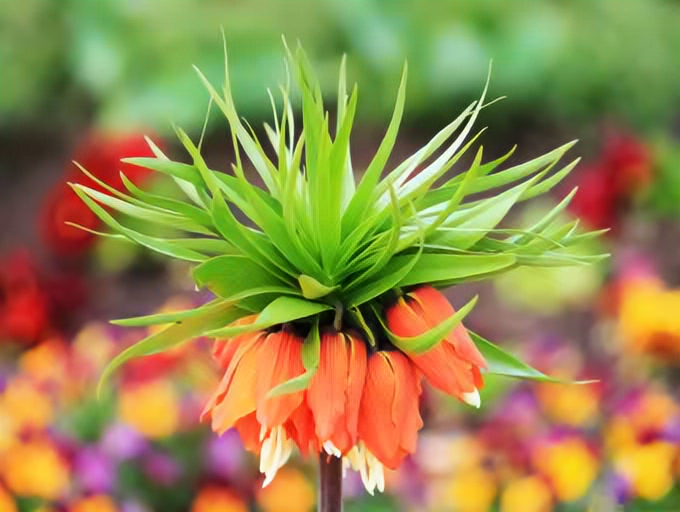

In [9]:
fn = data_1k.valid_dl.x.items[img_index]; fn

img = open_image(fn); print(img.shape)
p,img_hr,b = learn_gen.predict(img)

img_index += 1
p

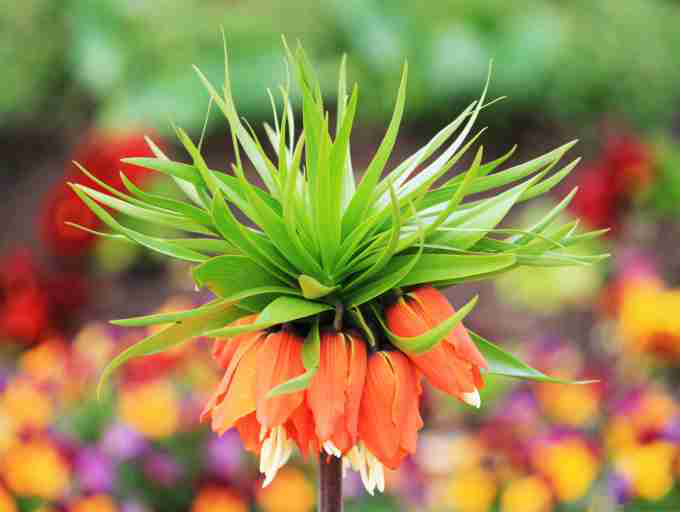

In [10]:
img